# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


##Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:
Since ICA generates vectors that underlie the data, I think that there will be a latent grocery group and a detergents / non - grocery grouping. Fresh, Milk, Grocery, Frozen, and Delicatessen could all be grouped into a "Food shopping" vector, while the other reason people come to the grocery store might be for non food stuffs like Detergents or Paper.

With PCA, it's hard to tell what would come out, since it is a linear combination of the underlying vectors. PCA seeks to compress the information space while preserving some structure of the data. As a result, I'm not sure which clumps will best represent the data, but as we'll see below it looks like "Fresh" and "Detergents_Paper"

###PCA

In [104]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

std = StandardScaler().fit(data)
std_data = std.transform(data)
pca = PCA(n_components=6).fit(std_data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.04288396 -0.54511832 -0.57925635 -0.05118859 -0.5486402  -0.24868198]
 [-0.52793212 -0.08316765  0.14608818 -0.61127764  0.25523316 -0.50420705]
 [-0.81225657  0.06038798 -0.10838401  0.17838615 -0.13619225  0.52390412]
 [-0.23668559 -0.08718991  0.10598745  0.76868266  0.17174406 -0.55206472]
 [ 0.04868278 -0.82657929  0.31499943  0.02793224  0.33964012  0.31470051]
 [ 0.03602539  0.03804019 -0.72174458  0.01563715  0.68589373  0.07513412]]
[ 0.44082893  0.283764    0.12334413  0.09395504  0.04761272  0.01049519]


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 
The first two components explain more than 70% of the variance. The next component only adds 12% of variance. Based on this drop off from two to three components, I would pick two components.

**3)** What do the dimensions seem to represent? How can you use this information?

### Is there a better way to do this? After some research, it's not clear to me how to besides iterating through each feature and seeing how it "fits" the projection.

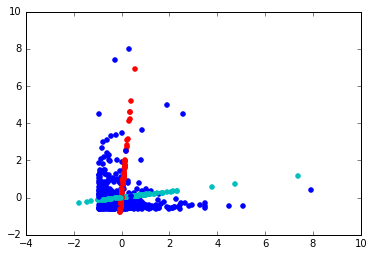

In [59]:
first_pc = pca.components_[0]
second_pc = pca.components_[1]

transformed_data = pca.transform(std_data)
for ii, jj in zip(transformed_data, np.array(std_data)):
    plt.scatter(first_pc[0]*ii[0], first_pc[1]*ii[0], color="r")
    plt.scatter(second_pc[0]*ii[1], second_pc[1]*ii[1], color="c")
    plt.scatter( jj[0], jj[4], color="b")

Answer: 

Based on some trial and error examination, it appears the first component is mostly 'Fresh' and the second component is mostly 'Detergents_Paper'. This information can be used to inform how customers behave on a grocery-related items dimension and a non-grocery items dimension. This distinction is intuitive to business users "of course there are grocery and non-grocery customers" and useful for grouping customers together.

### ICA

In [54]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA

ica = FastICA(n_components = 2, random_state=42).fit(std_data)

# Print the independent components
print ica.components_

[[-0.00374288  0.0146613   0.01778127 -0.0042903   0.01793892  0.00230984]
 [-0.01896353 -0.00704364  0.00079381 -0.0219689   0.00487822 -0.0196764 ]]


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: 

Based on the magnitude of the components returns from ICA, it looks like the first signal is mad of up of factor 2 and factor 4 (Grocery and Detergent). The second signal is made up of not factor 3 (frozen) and not factor 5 (Delicatessen).

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

K means has the advantage of being relatively straightforward to interpret. Further more, K-means scales relatively well and will always converge (whereas GMM is not guaranteed to converge). However, K-means requires hard assignment - an observation is either in a cluster or not. GMM on the other hand, assigns probabilities to clusters as soft assignment allowing us to interpret the uncertainty of a point's membership in a cluster.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [60]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [68]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduced_data = transformed_data[:,:2]
print reduced_data[:10]  # print upto 10 elements

[[-0.19329055  0.30509996]
 [-0.4344199   0.32841262]
 [-0.81114323 -0.8150957 ]
 [ 0.77864783 -0.65275373]
 [-0.16628726 -1.27143372]
 [ 0.15616993  0.29514099]
 [ 0.3352884   0.52500326]
 [-0.14058643  0.23099269]
 [ 0.51731954  0.65936283]
 [-1.59210908  0.74101133]]


In [71]:
from scipy.spatial.distance import cdist, pdist
# Decide on number clusters - courtesy of http://www.slideshare.net/SarahGuido/kmeans-clustering-with-scikitlearn
k_range = range(1,14)

# Fit a model for each k
k_means_var = [KMeans(n_clusters=k).fit(reduced_data) for k in k_range]

# Pull out centers
centroids = [X.cluster_centers_ for X in k_means_var]

# Calculated distance to center
k_euclid = [cdist(reduced_data, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]

# Within SS
wcss = [sum(d**2) for d in dist]

# Total SS
tss = sum(pdist(reduced_data)**2)/reduced_data.shape[0]

# between cluster ss
bss = tss - wcss


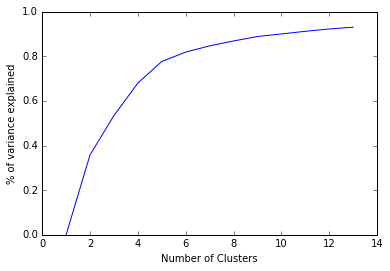

In [88]:
plt.plot(k_range, bss/tss)
plt.xlabel("Number of Clusters")
plt.ylabel("% of variance explained")

In [89]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
# Basedon the graph above, there's an "elbow" at about k=5
clusters = KMeans(n_clusters=5).fit(reduced_data)
print clusters

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)


In [90]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [91]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.cluster_centers_
print centroids

[[  0.75198268   0.20048468]
 [ -7.05027932   0.63634999]
 [ -4.51308525 -10.04070335]
 [  0.25039316  -1.6392017 ]
 [ -1.34002769   0.81001023]]


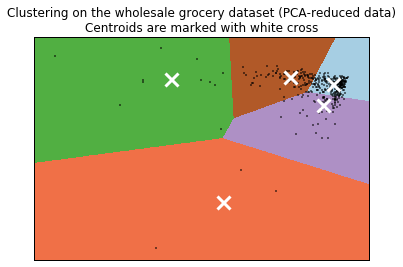

In [92]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

In [108]:
# Find some centroids...
print std.inverse_transform(pca.inverse_transform(np.hstack([centroids, np.zeros((centroids.shape[0], 4))])))

# Columns are:
#Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
# Get a sense of average values
print data.describe()

[[ 10255.81013714   2651.42569135   4094.51049407   2291.00119221
    1160.36125429    713.34896549]
 [ 11575.75815148  33738.3964026   47599.73788995   2935.70615055
   22076.40574756   5559.86842825]
 [ 81410.12439235  30088.63313126  18842.85798626  33954.61886688
    2468.7786494   18947.15792161]
 [ 22797.03960059   5795.04700559   4301.37252278   7868.66631445
     234.75001031   3677.62607985]
 [  7324.02560109  10684.6811194   16442.689291     1003.53986154
    7367.39356663   1313.11813349]]
               Fresh          Milk       Grocery        Frozen  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   5796.265909   7951.277273   3071.931818   
std     12647.328865   7380.377175   9503.162829   4854.673333   
min         3.000000     55.000000      3.000000     25.000000   
25%      3127.750000   1533.000000   2153.000000    742.250000   
50%      8504.000000   3627.000000   4755.500000   1526.000000   
75%     16933.750000   7190.2500

Answer: 

**Cluster 1**
This cluster has slightly below avg spending on Fresh produce, low spending on milk, low spending on groceries, about average on frozen foods, below average on detergents, and below average on delicatessen. I would describe these customers as low value: they don't shop much in any category.

**Cluster 2**
About average spending on fresh, enormous spending on milk (about 6 times average), enourmous spending on groceries (47k vs. ~8k average), average spending on frozen, enormous expenditures on detergents, and above average delicatessen spending. These are extremely valuable cheese eaters that spend lots of money at this store. Do you what you can to preserve them!

**Cluster 3**
This cluster spends a ton on Fresh food, a ton on milk, about twice average on groceries, enormous amounts of frozen foods, average detergents, and a large amount on delicatessens. These customers are also valuable, and tend to be more of the make a sandwhich and have some salad or sauteed frozen vegetables group.

**Cluster 4**
These customers spend a lot of fresh food, average on milk, below average groceries, a little above average frozen, very little on detergents, and above average on delicatessen. These customers present a growth opportunity by trying to get them to try some other products at the grocery store (like detergents).

**Cluster 5**
Cluster 5 spends below average on fresh foods, above average on milk, above average on groceries, very little on frozen food, a lot on detergents, and about average on delicatessen. These customer represent the milk, bread, and detergent shoppers and represent an opportunity to expand into the other grocery offerings besides the running errands trips.


### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 
Backing out values from the pca dimensions and inverting the transformations was really fun for spinning a story about the customers. It's find to see a plot with uninterperatble PCA dimensions and projections, but putting numbers to the clusters really brings the data to life.

**9)** How would you use that technique to help the company design new experiments?

Answer: 

I think an obvious extension here would be to try different promotional strategies. Clusters 4 and 5 present opportunities to expand into more general grocery items. An experiment might be to send 50% of your cluster 4 and 5 customers a coupon for 15% off on frozen foods, and the other 50% a coupon 10% off milk (which they already spend large amounts on). If they are amenable to expanding their baskets, we would expect them to start spending more on frozen foods since they already shop at the store. On the other hand, they might start buying frozen goods (since they were discounted) and spend less on the other categories already in their baskets.

**10)** How would you use that data to help you predict future customer needs?

Answer: 

Cluster 2 customers are the all stars and might be given extra access or care (for example a loyalty program) - as they are extremely valuable in all segments. You'd also want to make sure you can keep them from switching other competitors. Cluster 1 seems to be just the occasional shopper who might be attracted by promotions on important items like milk or produce. It would be important to calculate the lifetime value of a customer and make sure that if you do provide personalized coupons (or pricing), that your discounts don't exceed the expected value. For example, steeply discounted goods for the below spending cluster would have to attract a lot more of them in order to offse the lost dollars of the promotion.

One way to verify these models would be to use a classification technique (like logistic regression), with the outcome being whether they bought Groceries or not on a given trip. For each customer, you could then toss in the clusters as dummies on the right hand, but also more interesting information about the customers like their spend over the past 6 months, the number of trips, and annual income (if available). These clusters could also be used on the right hand side of a model to predict the likelihood of redeeming a coupon. With this liklihood (based on the above conditioning variables) we could calculate a customer lifetime value and set the expected value of purchase equal to the promotion amount (% discount * odds of redeeeming the coupon). This would have the result of giving richer discounts to the harder to acquire customers (fewer trips and spends).